In [74]:
# google drive
# from google.colab import drive
# drive.mount('/content/drive')
# file address in google drive
file_root = './'

In [75]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [76]:
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.models import ResNet50_Weights

In [77]:
def pltshow(img,gray=False):
    plt.figure(figsize=(5,5))
    plt.axis('off')
    if(gray):
        plt.imshow(img,cmap='gray')
    else:
        plt.imshow(img)
toPIL = transforms.ToPILImage()

In [170]:
# load and show original image
img = cv2.imread('%sbigou.jpg'%file_root)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
# load and show watermark image
wm = cv2.imread('%savatar2.jpg'%file_root)
wm = cv2.cvtColor(wm,cv2.COLOR_BGR2RGB)
wm = cv2.resize(wm,dsize=(img.shape[1],img.shape[0]),fx=1,fy=1,interpolation=cv2.INTER_LINEAR)

In [135]:
# image tranformation
T_3 = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize([256,256]),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
T_2 = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize([256,256])
])
T = transforms.ToTensor()

img_tensor =  T(img)
img_tensor = img_tensor.cuda()
wm_tensor = T(wm)
wm_tensor = wm_tensor.cuda()

In [80]:
from torch import Tensor
from torchvision.models.resnet import ResNet
from torch import nn
from typing import Optional, Any, List, Callable, Type, Union
from torchvision.models.resnet import BasicBlock,Bottleneck
class ResNet_with_trans(ResNet):
    def forward(self, x: Tensor) -> Tensor:
        x = transforms.Resize([256,256])(x)
        x = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(x)
        return self._forward_impl(x)

from torchvision.models.resnet import ResNet50_Weights
from torchvision.models._utils import _ovewrite_named_param
def resnet50_with_trans(*, weights: Optional[ResNet50_Weights] = None, progress: bool = True, **kwargs: Any) -> ResNet:
    weights = ResNet50_Weights.verify(weights)
    # model = _resnet(Bottleneck, [3, 4, 6, 3], weights, progress, **kwargs)
    block = Bottleneck
    layers = [3, 4, 6, 3]

    if weights is not None:
        _ovewrite_named_param(kwargs, "num_classes", len(weights.meta["categories"]))

    model = ResNet_with_trans(block, layers, **kwargs)

    if weights is not None:
        model.load_state_dict(weights.get_state_dict(progress=progress))
    
    return model

In [81]:
resnet = resnet50_with_trans(weights=ResNet50_Weights.IMAGENET1K_V1)
resnet = resnet.cuda()
resnet = resnet.eval()

In [82]:
# check classification result for single image
# param model: torch model
# param img: 4-dim image tensor
def check_classify(model,img):
    img = torch.unsqueeze(img,0).type(torch.FloatTensor).cuda()
    out = (F.softmax(model(img),dim=1))
    print(torch.max(out))
    print(out.argmax())

In [83]:
target = torch.tensor([162]).cuda()

In [84]:
# add border to image so that it can be divided perfectly with block_size
def addborder(img,block_size=8):
    diff_x = img.shape[0] % block_size
    diff_y = img.shape[1] % block_size
    if (diff_x==0 and diff_y==0):
        return img
    img = cv2.copyMakeBorder(img,
              0,(block_size-diff_x),
              0,(block_size-diff_y),
              cv2.BORDER_REPLICATE)
    return img

In [171]:
img = addborder(img)
img_tensor = T(img).cuda()
wm = cv2.resize(wm,dsize=(img.shape[1],img.shape[0]),fx=1,fy=1,interpolation=cv2.INTER_LINEAR)
wm_tensor = T(wm).cuda()

In [86]:
from tqdm import tqdm

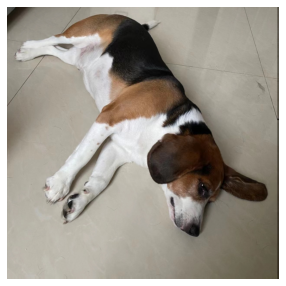

In [168]:
pltshow(toPIL(img_tensor))

In [87]:
def block_dct(bk,block_size=8):
    img_dct_blocks_h = bk.shape[0] // block_size
    img_dct_blocks_w = bk.shape[1] // block_size
    img_dct = np.zeros(shape = (bk.shape[0],bk.shape[1]))
# with tqdm(total=img_dct_blocks_h*img_dct_blocks_w) as pbar:
#     pbar.set_description('DCT Processing')
    for h in range(img_dct_blocks_h):
        for w in range(img_dct_blocks_w):
            a_block = bk[h*block_size:(h+1)*block_size,w*block_size:(w+1)*block_size]
            img_dct[h*block_size:(h+1)*block_size,w*block_size:(w+1)*block_size] =\
            cv2.dct(a_block.cpu().numpy())
            # pbar.update(1)
    return torch.from_numpy(img_dct).cuda()

def block_idct(bk,block_size=8):
    img_dct_blocks_h = bk.shape[0] // block_size
    img_dct_blocks_w = bk.shape[1] // block_size
    img_idct = np.zeros(shape = (bk.shape[0],bk.shape[1]))
# with tqdm(total=img_dct_blocks_h*img_dct_blocks_w) as pbar:
#     pbar.set_description('IDCT Processing')
    for h in range(img_dct_blocks_h):
        for w in range(img_dct_blocks_w):
            a_block = bk[h*block_size:(h+1)*block_size,w*block_size:(w+1)*block_size]
            img_idct[h*block_size:(h+1)*block_size,w*block_size:(w+1)*block_size] =\
            cv2.idct(a_block.cpu().numpy())
            # pbar.update(1)
    return torch.from_numpy(img_idct).cuda()

def dct_tensor(img):
    return torch.stack((block_dct(img[0,...]),block_dct(img[1,...]),block_dct(img[2,...])),dim=0)

def idct_tensor(img):
    return torch.stack((block_idct(img[0,...]),block_idct(img[1,...]),block_idct(img[2,...])),dim=0)

def embed_wm(img,wm,alpha):
    img_dct = dct_tensor(img)
    img_dct_wm = img_dct + alpha*wm
    img_wm_idct = idct_tensor(img_dct_wm)
    wmed_img = img_wm_idct.clip(0,1)
    return wmed_img

def extract_wm(img,wmed_img,alpha):
    img_dct = dct_tensor(img)
    wmed_dct = dct_tensor(wmed_img)
    wm = (wmed_dct-img_dct)/alpha
    return wm

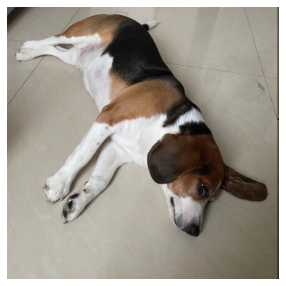

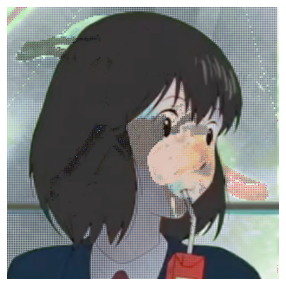

In [172]:
alpha = 0.1
wmed = embed_wm(img_tensor,wm_tensor,alpha)

pltshow(toPIL(wmed))

pltshow(toPIL(extract_wm(img_tensor,wmed,alpha)))

In [91]:
import torchattacks
beta = 1/255
pgd_atk = torchattacks.PGD(resnet, eps=8/255, alpha=beta, steps=40, random_start=True)
wmed_input = torch.unsqueeze(wmed,0).type(torch.FloatTensor)
adv_images = pgd_atk(wmed_input, target)
out_per = (F.softmax(resnet(adv_images),dim=1))
print(torch.max(out_per))
print(out_per.argmax())
pgd_wmed = adv_images[0,...]

tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
tensor(171, device='cuda:0')


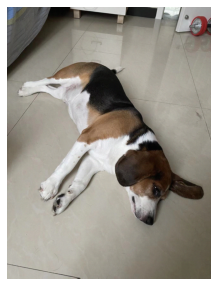

In [92]:
pltshow(toPIL(pgd_wmed))

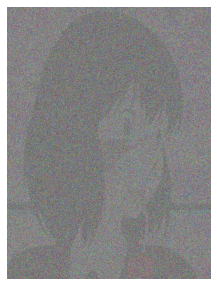

In [93]:
pltshow(toPIL(extract_wm(img_tensor,pgd_wmed,alpha)))

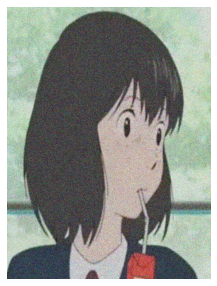

In [94]:
pgd_per = (pgd_wmed-wmed)/beta
per_dct = dct_tensor(pgd_per)

wm_per = per_dct * (beta/alpha)

wm_perturbed = (wm_per+wm_tensor).clip(0,1)

pltshow(toPIL(wm_perturbed))

In [95]:
adv_wm_test = embed_wm(img_tensor,wm_perturbed,alpha)
check_classify(resnet,adv_wm_test)

tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
tensor(171, device='cuda:0')


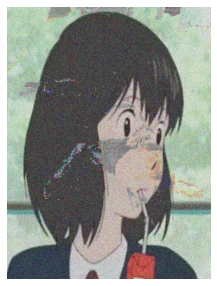

In [96]:
pltshow(toPIL(extract_wm(img_tensor,adv_wm_test,alpha)))

In [97]:
wm_extract = extract_wm(img_tensor,wmed,alpha)

In [98]:
wm_adv_origin = extract_wm(img_tensor,pgd_wmed,alpha)

In [99]:
wm_adv_new = extract_wm(img_tensor,adv_wm_test,alpha)

In [100]:
from torch import norm
norm(wm_extract-wm_tensor)

tensor(174.4381, device='cuda:0', dtype=torch.float64)

In [101]:
idct_wm = idct_tensor(wm_tensor)

In [102]:
dct_per = dct_tensor(pgd_per)

In [103]:
def alpha_update(alpha,beta,l1,l2,step,idct_wm,per,dct_per):
    grad = l1*norm(alpha*idct_wm+beta*per)*norm(idct_wm)-l2*(beta/alpha**2)*norm(dct_per)
    alpha_new = alpha - step*alpha
    if alpha_new < 0:
        alpha_new = alpha
    return alpha_new

In [104]:
l1 = 0.001
l2 = 0.001
s_a = 0.001
s_b = 0.001

In [105]:
a_test = alpha_update(alpha,beta,l1,l2,s_a,idct_wm,pgd_per,dct_per)

In [106]:
def beta_update(alpha,beta,l1,l2,step,idct_wm,per,dct_per):
    grad = l1*norm(alpha*idct_wm+beta*per)*norm(per)+l2*(1/alpha)*norm(dct_per)
    beta_new = beta - step*beta
    if beta_new < 0:
        beta_new = beta
    return beta_new

In [107]:
b_test = beta_update(alpha,beta,l1,l2,s_b,idct_wm,pgd_per,dct_per)

In [108]:
def check_out(model,img,target):
    img = torch.unsqueeze(img,0).type(torch.FloatTensor).cuda()
    out = (F.softmax(model(img),dim=1))
    out = out.argmax()
    return (out == target).item()

In [115]:
def opti(img,wm,model,atk,target,N,alpha,beta,l1,l2,s_a,s_b):
    wmed_origin = embed_wm(img,wm,alpha)
    wmed_input = torch.unsqueeze(wmed_origin,0).type(torch.FloatTensor).cuda()
    adv_images = atk(wmed_input, target)
    adv_wmed_origin = adv_images[0,...]
    per = (adv_wmed_origin-wmed_origin)/beta
    per_dct = dct_tensor(per)
    wm_per = per_dct * (beta/alpha)
    wm_perturbed = (wm_per+wm).clip(0,1)
    wmed = embed_wm(img,wm_perturbed,alpha)
    idct_wm = idct_tensor(wm)
    dct_per = dct_tensor(per)
    wm_res = wm_perturbed
    wmed_res = wmed
    with tqdm(total=N) as pbar:
        pbar.set_description('Optimization Processing')
        for n in range(N):
            alpha_new = alpha_update(alpha,beta,l1,l2,s_a,idct_wm,per,dct_per)
            beta_new = beta_update(alpha,beta,l1,l2,s_b,idct_wm,per,dct_per)
            wm_perturbed = (wm + (beta_new/alpha_new)*dct_per).clip(0,1)
            wmed = embed_wm(img,wm_perturbed,alpha_new)
            if check_out(model,wmed,target):
                return wm_res,wmed_res
            else:
                alpha = alpha_new
                beta = beta_new
                wm_res = wm_perturbed
                wmed_res = wmed
            pbar.update(1)   
        return wm_res,wmed_res,alpha,beta

In [116]:
N=10

In [117]:
wm_res, wmed_res,alpha,beta = opti(img_tensor,wm_tensor,resnet,pgd_atk,target,N,alpha,beta,l1,l2,s_a,s_b)

Optimization Processing: 100%|██████████████████████████████████████████████████████████| 10/10 [05:24<00:00, 32.45s/it]


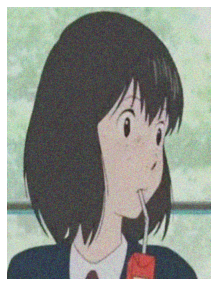

In [112]:
pltshow(toPIL(wm_res))

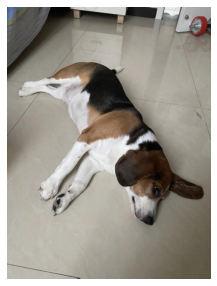

In [113]:
pltshow(toPIL(wmed_res))

In [114]:
check_classify(resnet,wmed_res)

tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
tensor(171, device='cuda:0')


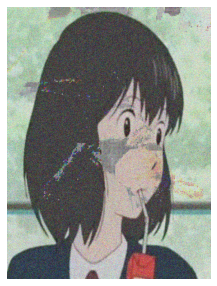

In [118]:
pltshow(toPIL(extract_wm(img_tensor,wmed_res,alpha)))

In [160]:
check_classify(resnet,img_tensor)

tensor(0.7537, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(162, device='cuda:0')
